# Import libs

In [1]:
library('igraph')
library('Matrix')
library('pracma')


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union


Attaching package: 'pracma'

The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu



# P 2.3 - PageRank

a) We are going to create a directed random network with $1000$ nodes, using the preferential attachment model. Note that in a directed preferential attachment network, the out-degree of every node is $m$, while the in-degrees follow a power law distribution. One problem of performing random walk in such a network is that, the very first node will have no outbounding edges, and be a "black hole" which a random walker can never "escape" from. To address that, let's generate another $1000$-node random network with preferential attachment model, and merge the two networks by adding the edges of the second graph to the first graph with a shuffling of the indices of the nodes. Create such a network using $m = 4$. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?

In [2]:
create_graph <- function(num_nodes=1000, custom_m=4) {
    # function that creates graphs for questions 2.3 and 2.4
    
    # create 2 random directed networks using PA model
    g_1dir <- sample_pa(num_nodes, m=custom_m, directed=TRUE)
    g_2dir <- sample_pa(num_nodes, m=custom_m, directed=TRUE)

    # create a vector of indices of length num_nodes
    idx <- seq(from = 1, to = num_nodes, by = 1)
    # permute the indices randomly
    idx <- sample(idx)
    # if permutation did not help
    while (idx[1] == 1) {
        # permute the indices randomly
        idx <- sample(idx)
    }
    # permute vertices of the second graph according to the indices vector
    g_2dir <- permute(g_2dir, idx)
    # get edges as a !proper! list
    g_2dir_edgelist <- c(t(as_edgelist(g_2dir)))

    # add new edges to the graph
    g_1dir_new <- add_edges(g_1dir, g_2dir_edgelist)
    
    return(g_1dir_new)
}

In [25]:
calculate_probabilities <- function(graph, trials, steps, alpha, teleportation_probs, deg_mode="in") {
    # the function calculates probabilities of visiting through random walk for each node
    # input variables:
    # graph:                   graph for which we will calculate probabilities
    # trials:                  the number of times we will init a completely new
    # steps:                   number of steps to perform at each iteration
    # alpha:                   probability of teleportation
    # teleportation_probs:     probabilities to teleport to each node  

    # returns:
    # probs_vs_degree:         a vector showing average prbability of visiting for a node with corresponding degree
    
    # calculate graph size
    num_nodes <- gorder(graph)
    # init array of node names
    node_names <- seq(from = 1, to = num_nodes, by = 1)
    # init array of visitis to each node
    visits <- c(zeros(1, num_nodes))
    
    # iterate "trials" times
    for (trial in 1:trials) {
        # choose starting point
        current_node <- sample(node_names, 1)
        # add visits to the array
        visits[current_node] <- visits[current_node] + 1
        # iterate "steps times"
        for (step in 1:steps) {
            # choose whether to teleport
            if (runif(1) > alpha) {
                # locate node's neighbours
                nbs <- neighbors(graph, current_node, mode = c("out"))
                # perform odrinary step
                current_node <- sample(nbs, 1)
            } else {
                # perform teleportation
                current_node <- sample(node_names, 1, prob = teleportation_probs)
            }
            # add visits to the array
            visits[current_node] <- visits[current_node] + 1
        }
    }
    
    # get probability of visiting each node
    visits <- visits / (trials * (1 + steps))
    # init array of probabilities as a function of degree
    probs_vs_degree <- c(zeros(1, num_nodes))
    # now for each degree we need to find all nodes with that degree and calculate average
    # probability of visiting said node; for that, init node counter
    deg_vs_nodes_counter <- c(zeros(1, num_nodes))
    # iterate through all nodes to find their degree and visit probability
    for (i in 1:num_nodes) {
        probs_vs_degree[degree(graph, v=i, mode=deg_mode)] <- probs_vs_degree[degree(graph, v=i, mode=deg_mode)] + visits[i]
        deg_vs_nodes_counter[degree(graph, v=i, mode=deg_mode)] <- deg_vs_nodes_counter[degree(graph, v=i, mode=deg_mode)] + 1
    }
    # now if there is at least one node with specified degree average probability over the number of nodes
    for (i in 1:num_nodes) {
        if (deg_vs_nodes_counter[i] != 0) {
            probs_vs_degree[i] <- probs_vs_degree[i] / deg_vs_nodes_counter[i]
        }
    }
    
    # return the result
    return(probs_vs_degree)
}

In [4]:
generate_mask <- function(vector_w_zeros) {
    # function that generates mask, which removes zero values from the vector
    
    # find which indices we need to remove
    to_remove <- which(vector_w_zeros == 0)
    # initialize mask
    mask <- c(ones(1, length(vector_w_zeros)))
    # mark elements we need to remove in the mask
    for (i in 1:length(vector_w_zeros)) {
        if (is.element(i, to_remove)) {
            mask[i] <- 0
        }
    }
    # convert mask to boolean
    mask <- mask > 0.5
    
    return(mask)
}

Let's gennerate one example graph to see how different algorithms affect degree distribution in its particular case

In [53]:
example_graph <- create_graph()

Let's see how random walk performs on that particular graph

In [54]:
# set number of trials for each graph
num_trails <- 50
# set number of steps
num_steps <- 500
# set teleportation probability
alpha <- 0
# calculate probabilities of visit
visiting_probs_default <- calculate_probabilities(example_graph, num_trails, num_steps, alpha, c())

png 
  2

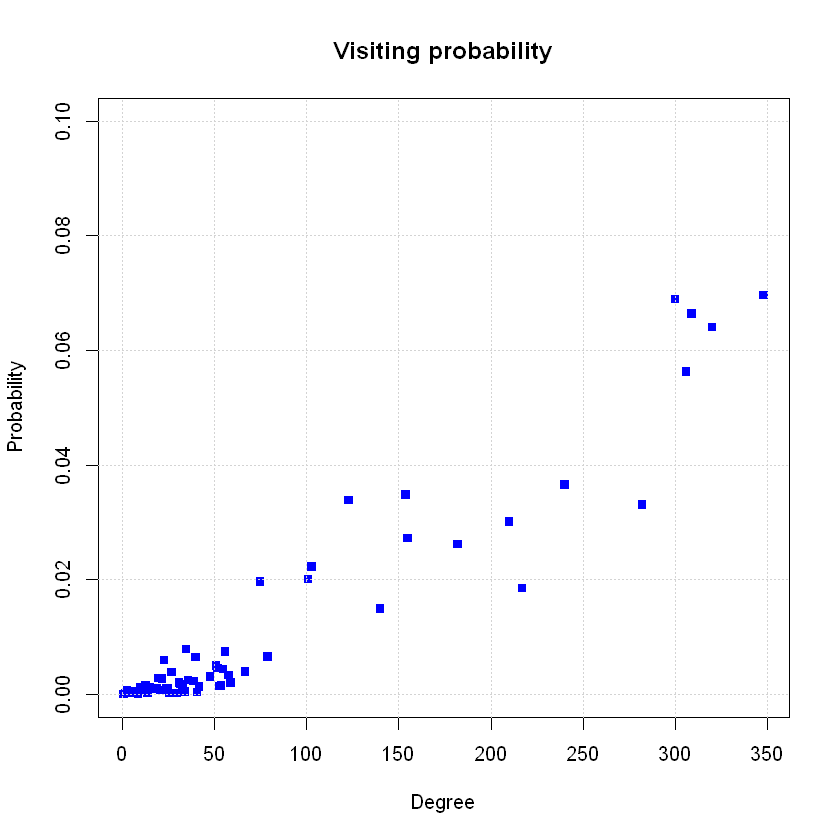

In [61]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(visiting_probs_default)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

grid()

# save plot
png(file="plots/2_3_a-1.png", width=600, height=450)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

grid()

dev.off()

Note: when I tried to run for 5000 iteration, the results were about the same, and the highest difference in probability was less than 0.01. For the sake of saving time, we will run for 500 iterations from now on.

**b)** In all previous questions, we didn't have any teleportation. Now, we use a teleportation probability of $\alpha = 0.15$. By performing random walks on the network created in 3(a), measure the probability that the walker visits each node. Is this probability related to the degree of the node?

In [56]:
# set number of trials for each graph
num_trails <- 50
# set number of steps
num_steps <- 500
# set teleportation probability
alpha <- 0.15

# create a set of unifrom probabilities
uni <- c(ones(1, 1000))
# calculate probabilities of visit
visiting_probs_teleport <- calculate_probabilities(example_graph, num_trails, num_steps, alpha, uni)

png 
  2

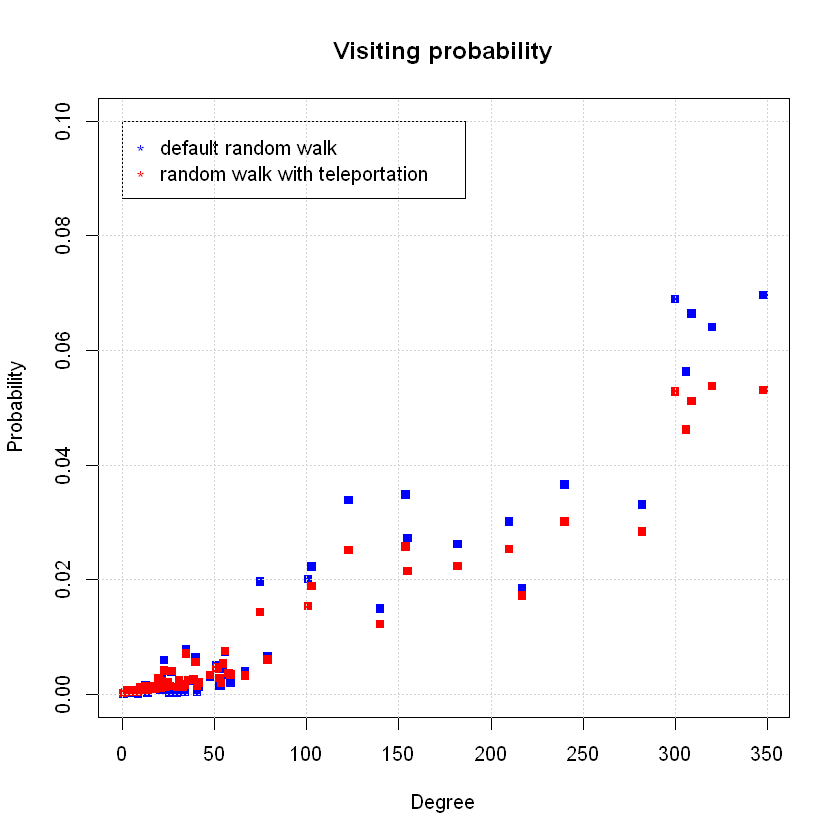

In [62]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(visiting_probs_teleport)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=7)
legend(0, 0.1, legend=c("default random walk", "random walk with teleportation"),
       col=c("blue", "red"), pch="*")
grid()

# save plot
png(file="plots/2_3_b-1.png", width=600, height=450)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=4,
     ylim=c(0, 0.1))

points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=4)
legend(0, 0.1, legend=c("default random walk", "random walk with teleportation"),
       col=c("blue", "red"), pch="*")
grid()

dev.off()

From the plot above, we can see that adding teleportation decreses visiting probability of the nodes with the high probability. This is because instead looping around these center node, the walker will sometimes teleport to the outskirts of the graph, so the number of visits to the nodes with very small degree also grows. 

<!-- The number of visits to their immideate outputs (nodes with degree 100-350) also generally increases, though some nodes close to teh center one (where the walker looped in the default case) also become less visited. -->

# P 2.4 - Personalized PageRank - previous version

**a)** Suppose you have your own notion of importance. Your interest in a node is proportional
to the node's PageRank, because you totally rely upon Google to decide which
website to visit (assume that these nodes represent websites). Again, use random
walk on network generated in question 3 to simulate this personalized PageRank.
Here the teleportation probability to each node is proportional to its PageRank (as
opposed to the regular PageRank, where at teleportation, the chance of visiting all
nodes are the same and equal to $\frac{1}{N}$. Again, let the teleportation probability be
equal to $\alpha = 0.15$. Compare the results with 3a).

In [58]:
# set number of trials for each graph
num_trails <- 50
# set number of steps
num_steps <- 500
# set teleportation probability
alpha <- 0.15

# find pagerank (with teleportation)
pr <- page_rank(example_graph)
# unpack pagerank
pr <- as.numeric(unlist(pr[1][seq(from = 1, to = 1000, by = 1)]))
# normilize the scores, for them to become probabilities
pr <- pr / sum(pr)

# calculate probabilities for current graph
visiting_probs_pagerank <- calculate_probabilities(example_graph, num_trails, num_steps, alpha, pr)

png 
  2

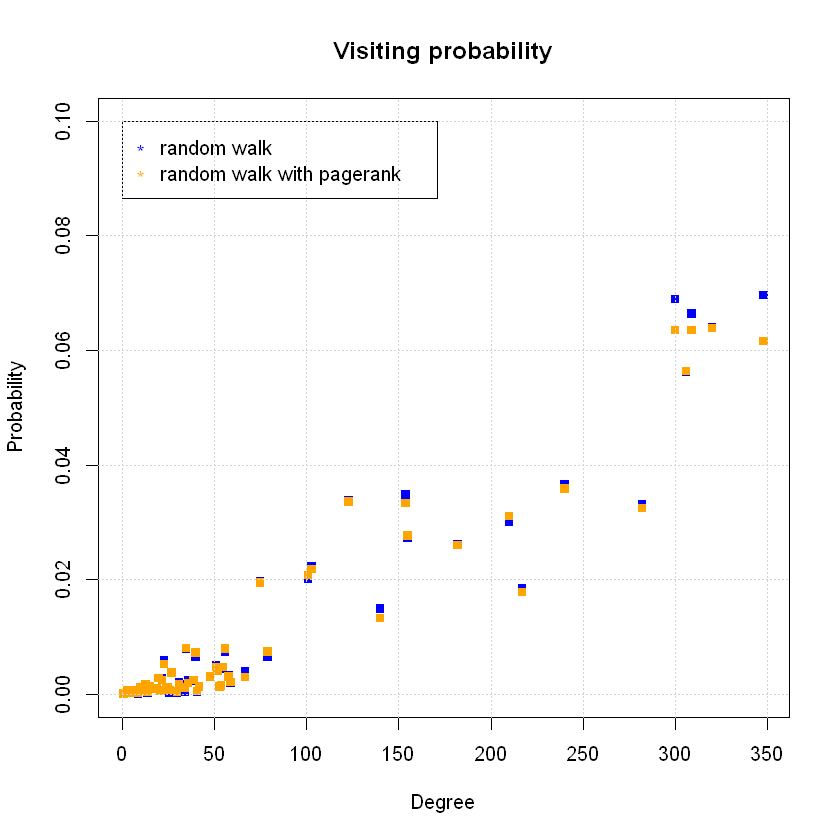

In [78]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(visiting_probs_teleport)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

# points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=4)
points(degrees[mask], visiting_probs_pagerank[mask], col="orange", pch=".", cex=7)

legend(0, 0.1, legend=c("random walk", "random walk with pagerank"),
       col=c("blue", "orange"), pch="*")
grid()

# save plot
png(file="plots/2_4_a-1.png", width=600, height=450)

plot(degrees[mask], visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

# points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=4)
points(degrees[mask], visiting_probs_pagerank[mask], col="orange", pch=".", cex=7)

legend(0, 0.1, legend=c("random walk", "random walk with pagerank"),
       col=c("blue", "orange"), pch="*")
grid()

dev.off()

We can see that teleportation in accordance with pagerank scores (note: pagerank is computed for teleportation probability of $\alpha=0.15$, because computation for $\alpha=0$ isn't possibble for most of the graphs) strongly increases visiting probbability of center node and several nodes adjusted to it, while decreasing probability of all other ones. This is because now the central node has the highest chance to being teleported to, so even if a walker randomly entered outskirts it gets returned to the center. This negatively affects visiting chance of all other nodes.

**b)** Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the PageRank values affected?

In [59]:
# set number of trials for each graph
num_trails <- 50
# set number of steps
num_steps <- 500
# set teleportation probability
alpha <- 0.15

# find pagerank (with teleportation)
pr <- page_rank(example_graph)
# unpack pagerank
pr <- as.numeric(unlist(pr[1][seq(from = 1, to = 1000, by = 1)]))
# sort pagerank scores
sorted_idxs <- order(pr)
# init array for personalized pagerank
personalized_pr <- c(zeros(1, 1000))
# set median probabilities to 1/2
personalized_pr[sorted_idxs[500]] = 1/2
personalized_pr[sorted_idxs[501]] = 1/2

# calculate probabilities for current graph
visiting_probs_personalized_pagerank <- calculate_probabilities(example_graph, num_trails, num_steps, alpha, personalized_pr)

png 
  2

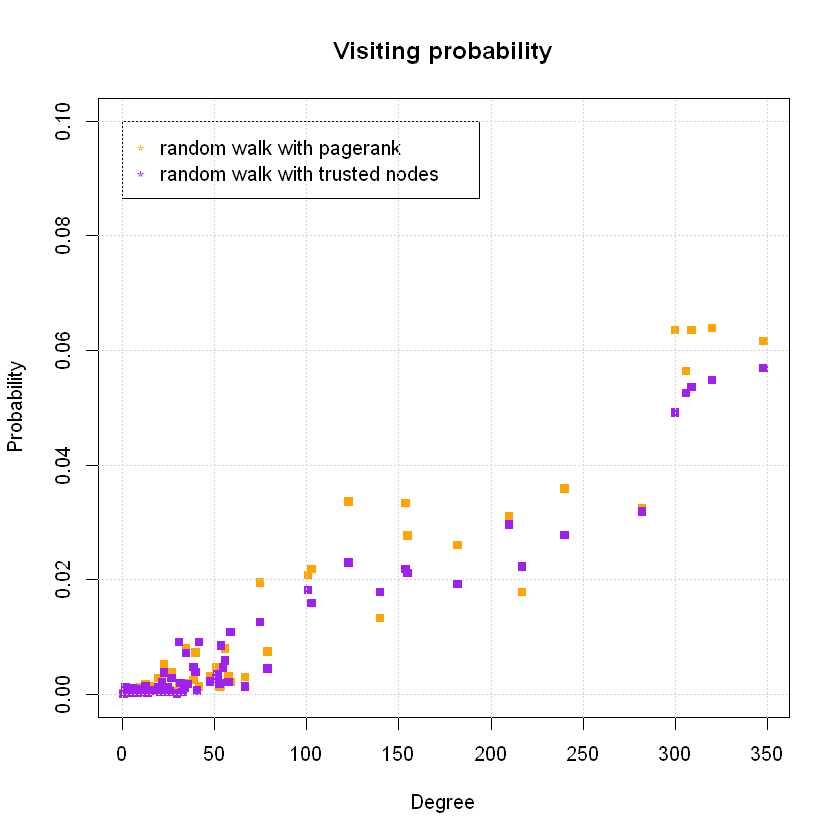

In [64]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(visiting_probs_teleport)

plot(degrees[mask], visiting_probs_pagerank[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="orange",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

# points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=4)
points(degrees[mask], visiting_probs_personalized_pagerank[mask], col="purple", pch=".", cex=7)

legend(0, 0.1, legend=c("random walk with pagerank", "random walk with trusted nodes"),
       col=c("orange", "purple"), pch="*")
grid()

# save plot
png(file="plots/2_4_b-1.png", width=600, height=450)

plot(degrees[mask], visiting_probs_pagerank[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="orange",
     pch=".",
     cex=7,
     ylim=c(0, 0.1))

# points(degrees[mask], visiting_probs_teleport[mask], col="red", pch=".", cex=4)
points(degrees[mask], visiting_probs_personalized_pagerank[mask], col="purple", pch=".", cex=7)

legend(0, 0.1, legend=c("random walk with pagerank", "random walk with trusted nodes"),
       col=c("orange", "purple"), pch="*")
grid()

dev.off()

Teleportation to trusted nodes punishes the nodes with highest visiting probabilities (as algorithm does not work in their favor anymore), while increasing probabilities of visit for nodes in the middle. This is because trusted nodes had probabilities of visiting somewhere in the middle, similar to nodes connected to them. The nodes with small degrees obviously have low chance of being visited.

Now let's generate $\sim 1000$ (change after test) random graphs and see if that trend persists on average

In [65]:
# set number of graphs
num_graphs <- 3000
# set number of trials for each graph
num_trails <- 2
# set number of steps
num_steps <- 500


print("starting")
flush.console()

# init visiting probabilities as a function of degree for all methods
avg_visiting_probs_default <- zeros(1, 1000)
avg_visiting_probs_teleport <- zeros(1, 1000)
avg_visiting_probs_pagerank <- zeros(1, 1000)
avg_visiting_probs_personalized_pagerank <- zeros(1, 1000)
# init counter to find out how often nodes with specified degree were present in the graphs
degree_counter <- zeros(1, 1000)

# time the code
ptm <- proc.time()

for (h in 1:num_graphs) {
        
    # create graph
    temp_g <- create_graph()
    
    # create a set of unifrom probabilities
    uni <- c(ones(1, 1000)) / 1000
    # find pagerank (with teleportation)
    pr <- page_rank(temp_g)
    # unpack pagerank
    pr <- as.numeric(unlist(pr[1][seq(from = 1, to = 1000, by = 1)]))
    # normilize the scores, for them to become probabilities
    pr <- pr / sum(pr)
    # sort pagerank scores
    sorted_idxs <- order(pr)
    # init array for personalized pagerank
    personalized_pr <- c(zeros(1, 1000))
    # set median probabilities to 1/2
    personalized_pr[sorted_idxs[500]] = 1/2
    personalized_pr[sorted_idxs[501]] = 1/2
    
    # calculate probabilities for current graph
    avg_visiting_probs_default <- avg_visiting_probs_default + calculate_probabilities(temp_g, num_trails, num_steps, 0, c())
    avg_visiting_probs_teleport <- avg_visiting_probs_teleport + calculate_probabilities(temp_g, num_trails, num_steps, 0.15, uni)
    avg_visiting_probs_pagerank <- avg_visiting_probs_pagerank + calculate_probabilities(temp_g, num_trails, num_steps, 0.15, pr)
    avg_visiting_probs_personalized_pagerank <- avg_visiting_probs_personalized_pagerank + calculate_probabilities(temp_g, num_trails, num_steps, 0.15, personalized_pr)
    
    # check which degrees were present in the graph
    degs <- degree_distribution(temp_g, mode="in") * 1000
    for (i in 1:length(degs)) {
        if (degs[i] > 0) {
            degree_counter[i] <- degree_counter[i] + 1
        }
    }
    
    
    if (h %% 25 == 0) {
        # do not forget to flush console to be able to print inside the loop
        print(c("calculating for graph", h))
        flush.console()
        
        # print out time
        print(proc.time() - ptm)
        flush.console()
        
        
        # time the code
        ptm <- proc.time()
    }
    

}


# normilize probs
for (i in 1:1000) {
    if (degree_counter[i] > 0) {
        avg_visiting_probs_default[i] <- avg_visiting_probs_default[i] / degree_counter[i]
        avg_visiting_probs_teleport[i] <- avg_visiting_probs_teleport[i] / degree_counter[i]
        avg_visiting_probs_pagerank[i] <- avg_visiting_probs_pagerank[i] / degree_counter[i]
        avg_visiting_probs_personalized_pagerank[i] <- avg_visiting_probs_personalized_pagerank[i] / degree_counter[i]
    }
}

[1] "starting"
[1] "calculating for graph" "25"                   
   user  system elapsed 
 178.26    3.38  181.90 
[1] "calculating for graph" "50"                   
   user  system elapsed 
 172.79    3.30  176.35 
[1] "calculating for graph" "75"                   
   user  system elapsed 
 183.18    3.70  187.14 
[1] "calculating for graph" "100"                  
   user  system elapsed 
 198.92    3.28  202.78 
[1] "calculating for graph" "125"                  
   user  system elapsed 
 223.66    3.53  227.84 
[1] "calculating for graph" "150"                  
   user  system elapsed 
 196.31    3.17  200.00 
[1] "calculating for graph" "175"                  
   user  system elapsed 
 184.91    3.36  188.58 
[1] "calculating for graph" "200"                  
   user  system elapsed 
 191.27    3.69  195.25 
[1] "calculating for graph" "225"                  
   user  system elapsed 
 188.93    3.44  193.42 
[1] "calculating for graph" "250"                  
   user  system

   user  system elapsed 
 131.57    2.57  134.17 
[1] "calculating for graph" "2050"                 
   user  system elapsed 
 132.51    2.91  135.47 
[1] "calculating for graph" "2075"                 
   user  system elapsed 
 131.99    2.45  134.45 
[1] "calculating for graph" "2100"                 
   user  system elapsed 
 133.73    2.41  136.16 
[1] "calculating for graph" "2125"                 
   user  system elapsed 
 132.57    2.64  135.32 
[1] "calculating for graph" "2150"                 
   user  system elapsed 
 133.66    2.27  135.93 
[1] "calculating for graph" "2175"                 
   user  system elapsed 
 132.09    2.73  134.85 
[1] "calculating for graph" "2200"                 
   user  system elapsed 
 132.71    2.77  135.50 
[1] "calculating for graph" "2225"                 
   user  system elapsed 
 132.59    2.76  135.36 
[1] "calculating for graph" "2250"                 
   user  system elapsed 
 131.57    3.08  134.67 
[1] "calculating for graph" "227

png 
  2

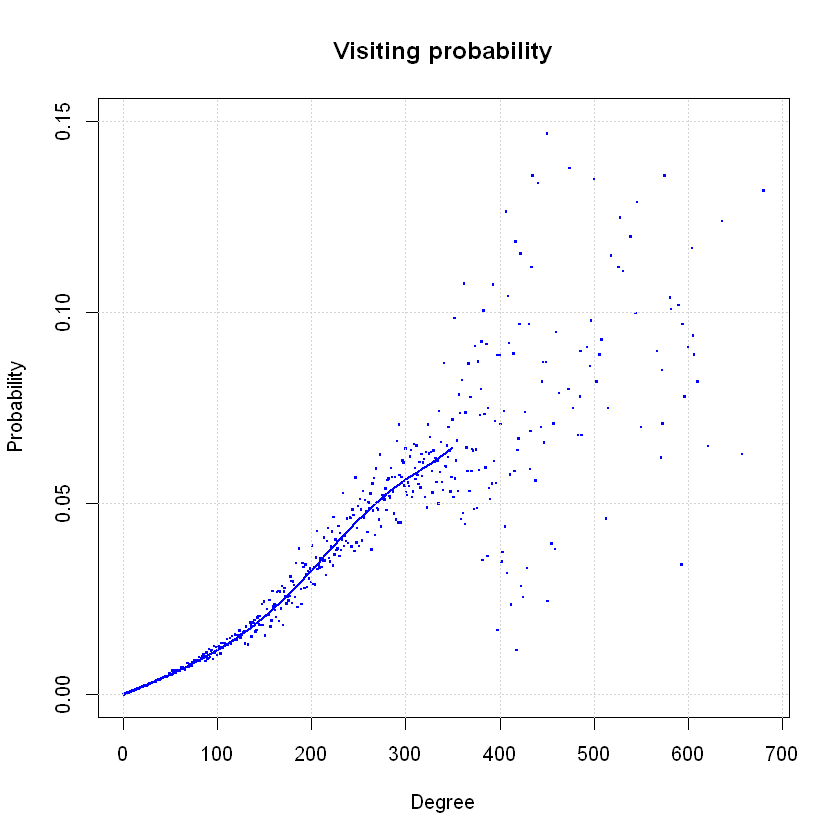

In [66]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(avg_visiting_probs_default)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.15))

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.8)

line1 <- predict(lo1)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)

grid()

# save plot
png(file="plots/2_3_a-2.png", width=600, height=450)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.15))

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.8)

line1 <- predict(lo1)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)

grid()

dev.off()

png 
  2

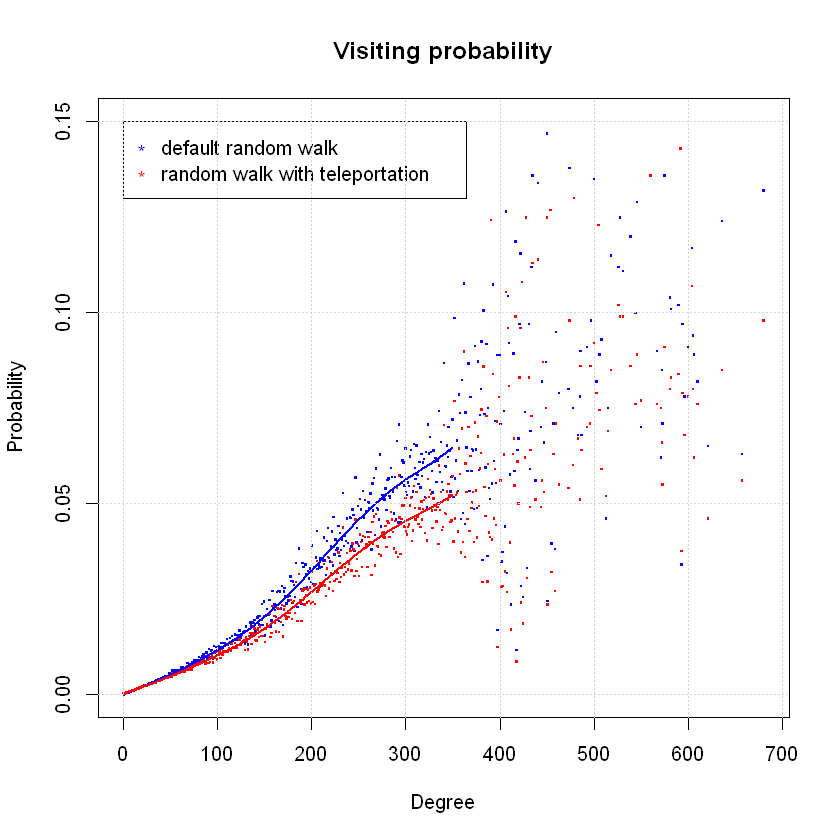

In [67]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(avg_visiting_probs_default)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.15))

points(degrees[mask], avg_visiting_probs_teleport[mask], col="red", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.8)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_teleport[mask], spar=0.8)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)
lines(predict(lo2)$y[0:350], col='red', lwd=2)

legend(0, 0.15, legend=c("default random walk", "random walk with teleportation"),
       col=c("blue", "red"), pch="*")

grid()

# save plot
png(file="plots/2_3_b-2.png", width=600, height=450)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.15))

points(degrees[mask], avg_visiting_probs_teleport[mask], col="red", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.8)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_teleport[mask], spar=0.8)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)
lines(predict(lo2)$y[0:350], col='red', lwd=2)

legend(0, 0.15, legend=c("default random walk", "random walk with teleportation"),
       col=c("blue", "red"), pch="*")

grid()

dev.off()

png 
  2

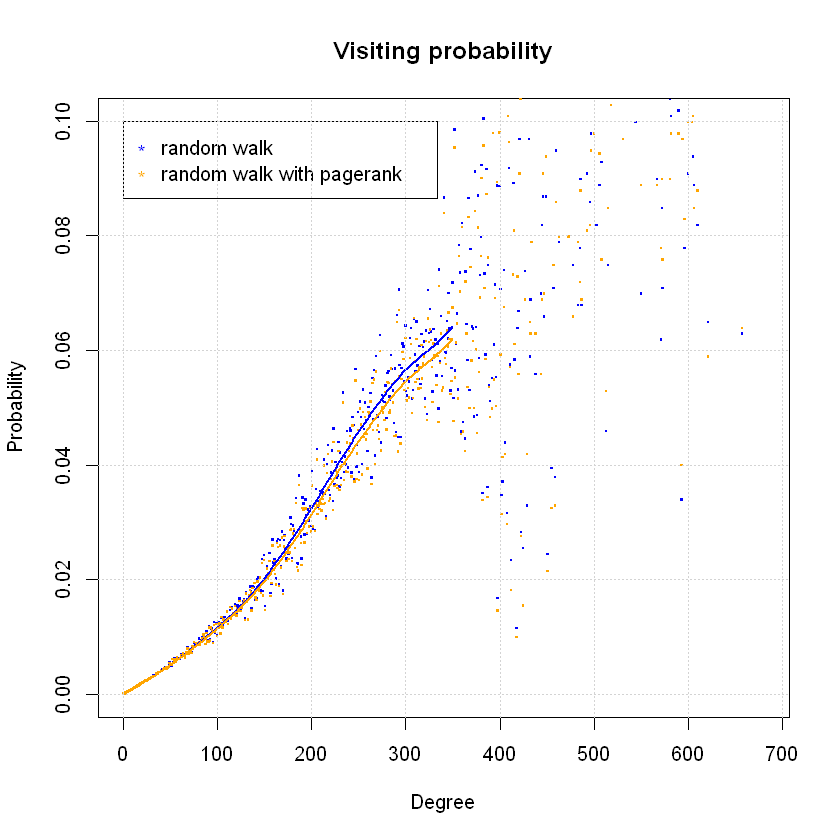

In [79]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(avg_visiting_probs_default)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.1))

points(degrees[mask], avg_visiting_probs_pagerank[mask], col="orange", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.7)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_pagerank[mask], spar=0.7)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)
lines(predict(lo2)$y[0:350], col='orange', lwd=2)

legend(0, 0.1, legend=c("random walk", "random walk with pagerank"),
       col=c("blue", "orange"), pch="*")

grid()

# save plot
png(file="plots/2_4_a-2.png", width=600, height=450)

plot(degrees[mask], avg_visiting_probs_default[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="blue",
     pch=".",
     cex=2,
     ylim=c(0, 0.1))

points(degrees[mask], avg_visiting_probs_pagerank[mask], col="orange", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_default[mask], spar=0.7)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_pagerank[mask], spar=0.7)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='blue', lwd=2)
lines(predict(lo2)$y[0:350], col='orange', lwd=2)

legend(0, 0.1, legend=c("random walk", "random walk with pagerank"),
       col=c("blue", "orange"), pch="*")

grid()

dev.off()

png 
  2

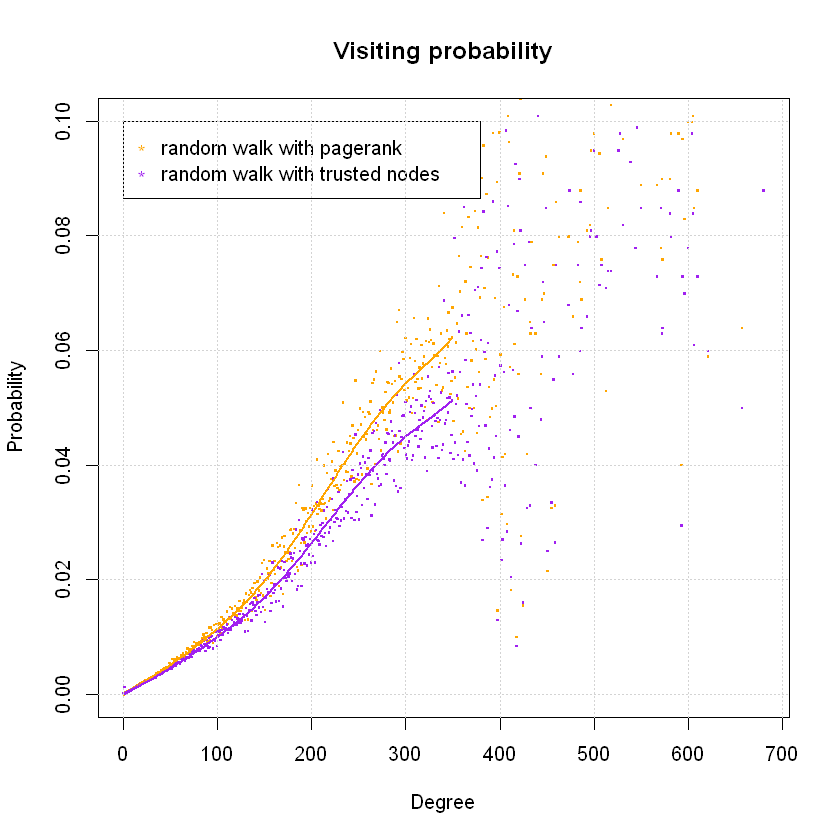

In [82]:
# convert data to the form acceptable for plotting
degrees <- seq(from=1, to=1000, by=1)
mask <- generate_mask(avg_visiting_probs_default)

plot(degrees[mask], avg_visiting_probs_pagerank[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="orange",
     pch=".",
     cex=2,
     ylim=c(0, 0.1))

points(degrees[mask], avg_visiting_probs_personalized_pagerank[mask], col="purple", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_pagerank[mask], spar=0.8)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_personalized_pagerank[mask], spar=0.8)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='orange', lwd=2)
lines(predict(lo2)$y[0:350], col='purple', lwd=2)

legend(0, 0.1, legend=c("random walk with pagerank", "random walk with trusted nodes"),
       col=c("orange", "purple"), pch="*")

grid()

# save plot
png(file="plots/2_4_b-2.png", width=600, height=450)

plot(degrees[mask], avg_visiting_probs_pagerank[mask],
     main="Visiting probability",
     xlab="Degree",
     ylab="Probability",
     col="orange",
     pch=".",
     cex=2,
     ylim=c(0, 0.1))

points(degrees[mask], avg_visiting_probs_personalized_pagerank[mask], col="purple", pch=".", cex=2)

lo1 <- smooth.spline(degrees[mask], avg_visiting_probs_pagerank[mask], spar=0.8)
lo2 <- smooth.spline(degrees[mask], avg_visiting_probs_personalized_pagerank[mask], spar=0.8)

line1 <- predict(lo1)
line2 <- predict(lo2)

lines(predict(lo1)$y[0:350], col='orange', lwd=2)
lines(predict(lo2)$y[0:350], col='purple', lwd=2)

legend(0, 0.1, legend=c("random walk with pagerank", "random walk with trusted nodes"),
       col=c("orange", "purple"), pch="*")

grid()

dev.off()

# Helper functions

In [ ]:
plot(g_test, edge.arrow.size=.4, edge.curved=.1, vertex.size=1, vertex.label=NA)

In [64]:
temp_sc <- page_rank(temp_g)
temp_sc <- as.numeric(unlist(temp_sc[1][seq(from = 1, to = 1000, by = 1)]))
print(temp_sc)

   [1] 0.0448673927 0.0338151149 0.0395835031 0.0222509698 0.0266277453
   [6] 0.0138748866 0.0100051961 0.0118842208 0.0056638683 0.0010856615
  [11] 0.0095178880 0.0183740780 0.0033183219 0.0005552176 0.0066008126
  [16] 0.0010499643 0.0028581962 0.0063947474 0.0049816732 0.0036018740
  [21] 0.0015308504 0.0012476829 0.0005663178 0.0018060536 0.0005651762
  [26] 0.0002252026 0.0057610021 0.0007346347 0.0002354309 0.0013535218
  [31] 0.0013095900 0.0037869041 0.0016891659 0.0043133704 0.0020292005
  [36] 0.0012919701 0.0015960421 0.0001839282 0.0029826662 0.0004097761
  [41] 0.0005658172 0.0011562396 0.0003846760 0.0002631910 0.0004938409
  [46] 0.0173059266 0.0131794853 0.0007896257 0.0013598222 0.0006222577
  [51] 0.0001659375 0.0005946478 0.0001500000 0.0007163122 0.0005664792
  [56] 0.0004585297 0.0030040124 0.0116500295 0.0008592047 0.0129965299
  [61] 0.0014096439 0.0006690134 0.0088191080 0.0008524934 0.0001978125
  [66] 0.0002597001 0.0022990033 0.0002724520 0.0185225247 0.000